# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [7]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"))

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


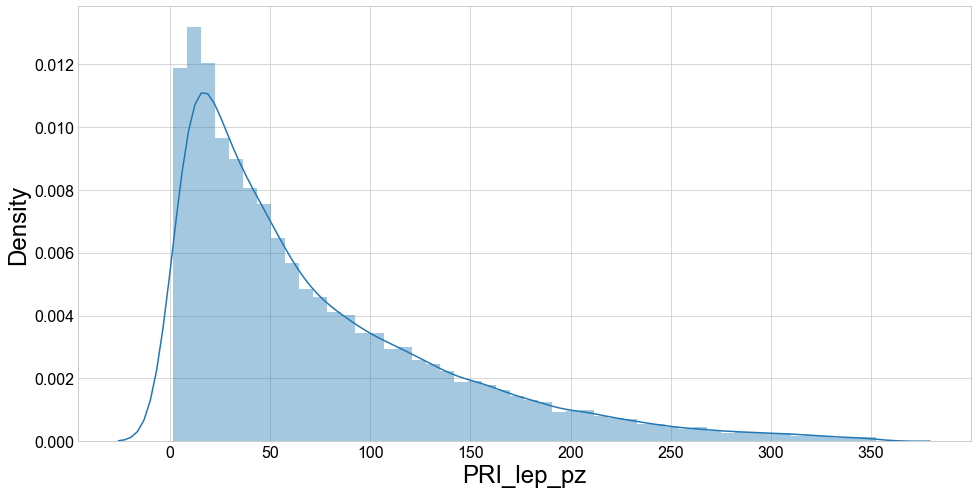

/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


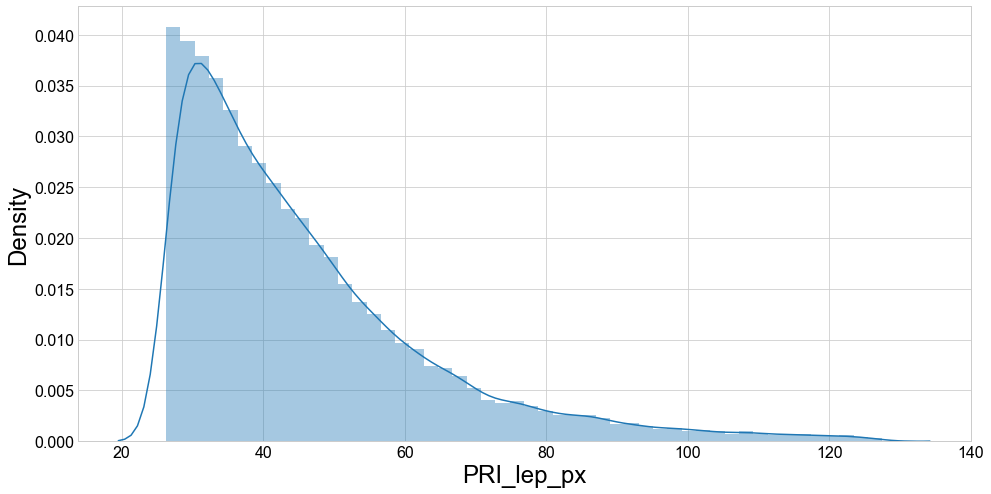

/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


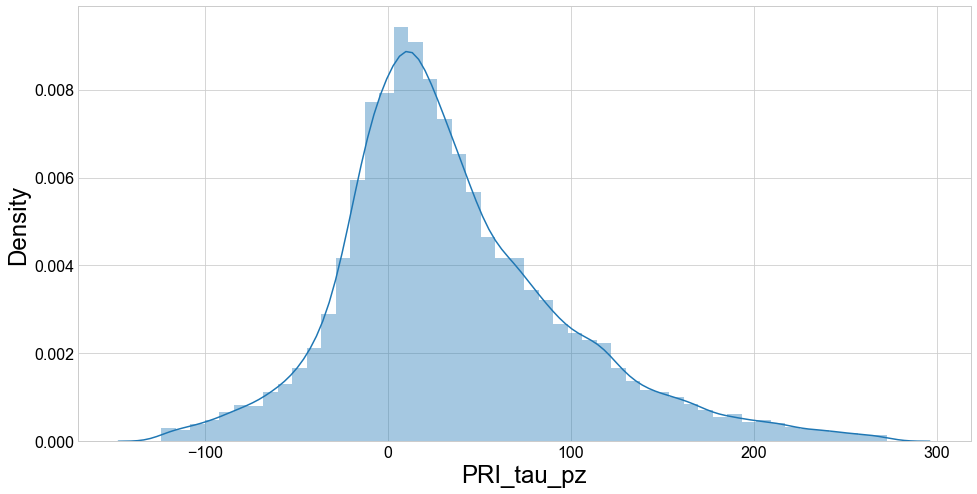

/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


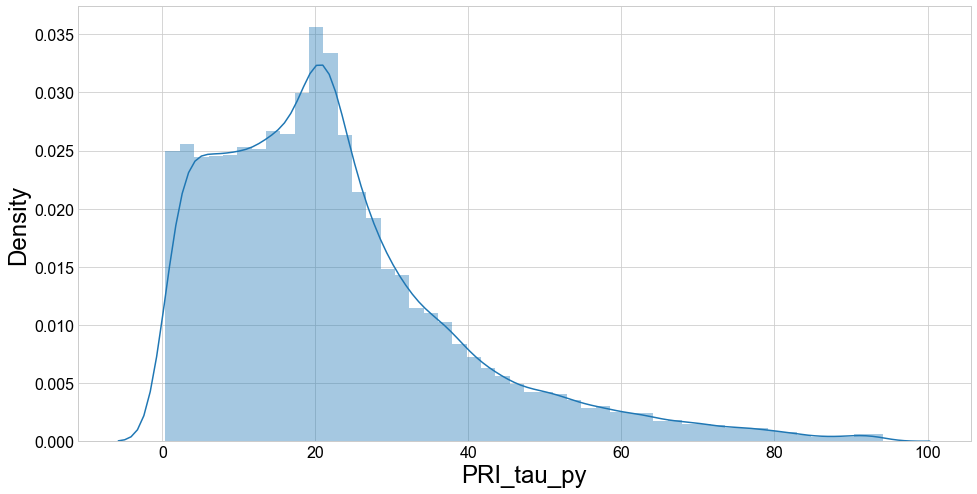

/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


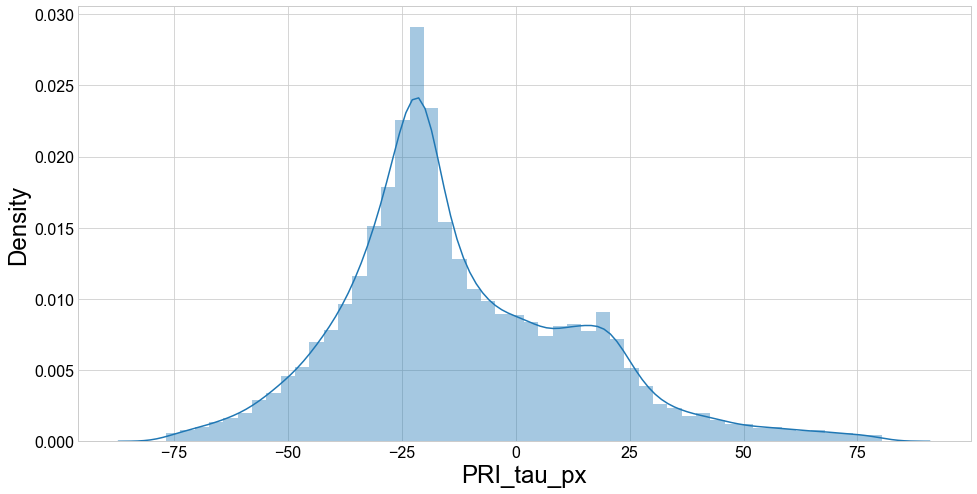

In [10]:
data = pd.DataFrame(input_pipe.inverse_transform(np.array(train_fy.source['fold_0/inputs'])), columns=train_feats)
plot_feat(data, 'PRI_lep_pz')
plot_feat(data, 'PRI_lep_px')
plot_feat(data, 'PRI_tau_pz')
plot_feat(data, 'PRI_tau_py')
plot_feat(data, 'PRI_tau_px')

## Determine LR

2 classes found, running in binary mode



/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 10.890s 


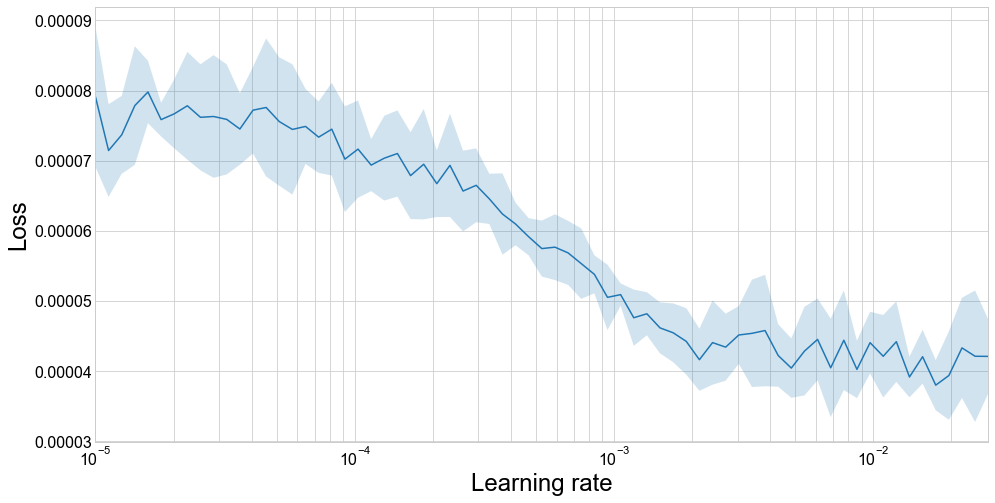

______________________________________



In [11]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [12]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode

1 New best found: 3.802903419418726e-05
2 New best found: 3.59078167413827e-05
3 New best found: 3.514464713662164e-05
5 New best found: 3.4475657837174366e-05
6 New best found: 3.402623786532786e-05
7 New best found: 3.397016976232407e-05
11 New best found: 3.368432940042112e-05
13 New best found: 3.348003276187228e-05
14 New best found: 3.334560623043217e-05
15 New best found: 3.332793485024013e-05
23 New best found: 3.314861669787206e-05
24 New best found: 3.3068996676593086e-05
26 New best found: 3.298993985663401e-05
27 New best found: 3.29506748021231e-05
28 New best found: 3.284895740071079e-05
29 New best found: 3.2837562121858356e-05
51 New best found: 3.28109066162142e-05
53 New best found: 3.274026609433349e-05
56 New best found: 3.2733512271079234e-05
57 New best found: 3.273119843652239e-05
60 New best found: 3.2700246019521726e-05
61 New best found: 3.2694401747

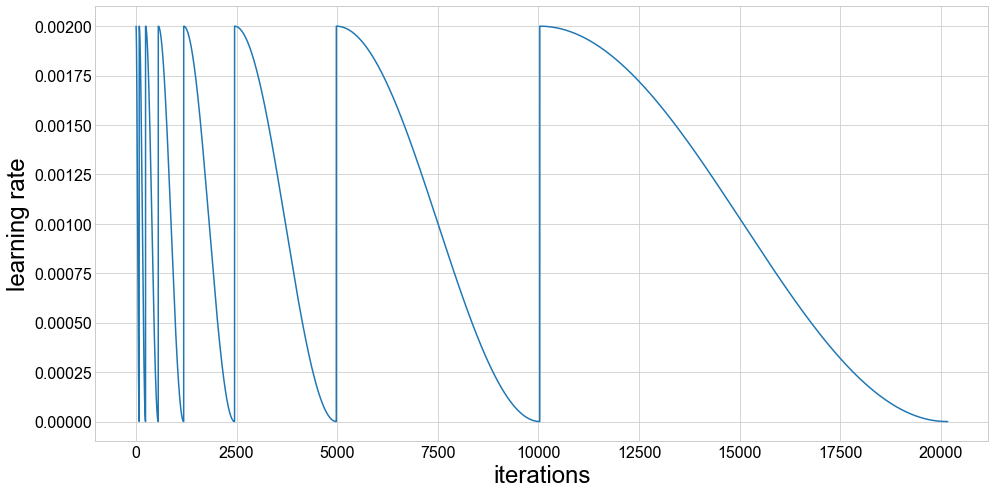

Fold took 131.385s

Training model 2 / 10
Using cosine LR annealing
1 New best found: 3.614423355725527e-05
2 New best found: 3.479160771427045e-05
3 New best found: 3.402704106917164e-05
5 New best found: 3.3479752514412426e-05
6 New best found: 3.305586481572987e-05
7 New best found: 3.2843825740851696e-05
10 New best found: 3.281796841274035e-05
11 New best found: 3.271633276937328e-05
12 New best found: 3.251456801543123e-05
13 New best found: 3.240366169142418e-05
14 New best found: 3.230189333814107e-05
15 New best found: 3.2259850390556256e-05
24 New best found: 3.22386175532694e-05
25 New best found: 3.2153751104907155e-05
26 New best found: 3.196081640641169e-05
27 New best found: 3.193688924925866e-05
30 New best found: 3.1932633836832296e-05
31 New best found: 3.192456259920571e-05
53 New best found: 3.185062327650687e-05
54 New best found: 3.1834192348680895e-05
59 New best found: 3.181928296287902e-05
60 New best found: 3.180340474833991e-05
62 New best found: 3.1802048340

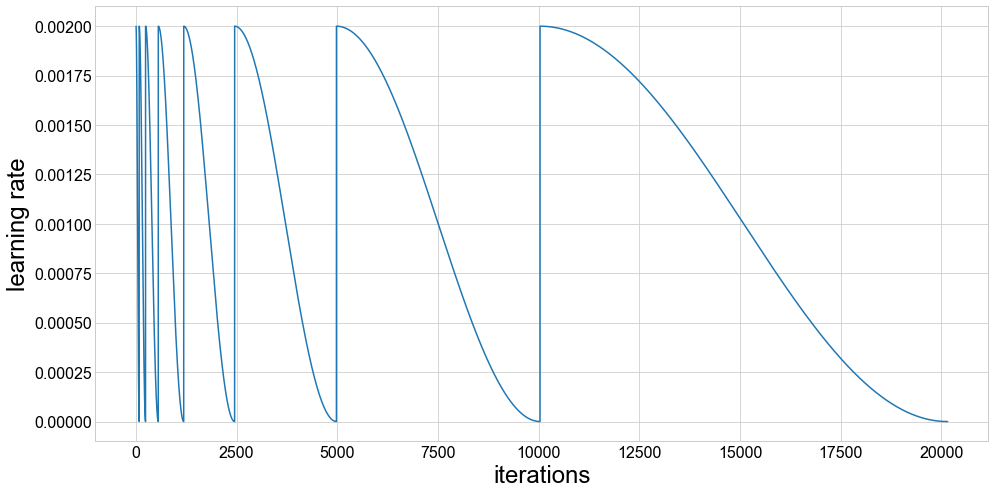

Fold took 128.595s

Training model 3 / 10
Using cosine LR annealing
1 New best found: 3.737854957144009e-05
2 New best found: 3.5408522486977746e-05
3 New best found: 3.453623577952385e-05
4 New best found: 3.4257288435765073e-05
5 New best found: 3.3819748015957886e-05
6 New best found: 3.331740370340413e-05
7 New best found: 3.32582537070266e-05
10 New best found: 3.3081724577641584e-05
11 New best found: 3.2953511268715374e-05
12 New best found: 3.270347140787635e-05
14 New best found: 3.2558643641823435e-05
15 New best found: 3.2510564233234617e-05
24 New best found: 3.224096892081434e-05
25 New best found: 3.2193293940508735e-05
26 New best found: 3.213289732520934e-05
27 New best found: 3.2083617318130564e-05
28 New best found: 3.198616732552182e-05
29 New best found: 3.193845378409605e-05
30 New best found: 3.191613534872886e-05
48 New best found: 3.189738581859274e-05
52 New best found: 3.174094631394837e-05
53 New best found: 3.1689632215420716e-05
56 New best found: 3.1677738

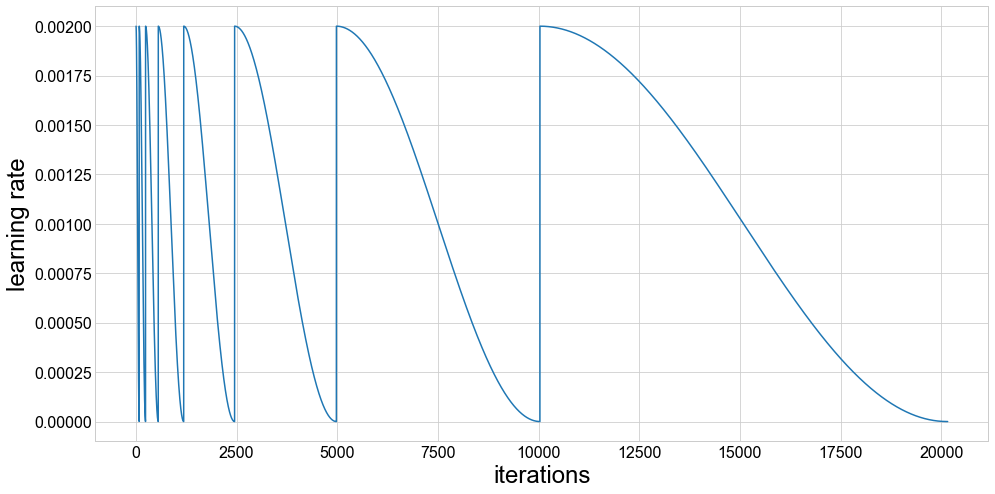

Fold took 134.024s

Training model 4 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102894). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7020442911645966e-05
2 New best found: 3.4871027839771265e-05
3 New best found: 3.431314785625789e-05
5 New best found: 3.3854387169337495e-05
6 New best found: 3.319392591090539e-05
7 New best found: 3.315157711679235e-05
9 New best found: 3.3037270180862555e-05
10 New best found: 3.284702983333953e-05
12 New best found: 3.255485856332284e-05
13 New best found: 3.244870405121267e-05
14 New best found: 3.232215455713096e-05
15 New best found: 3.2317153149582035e-05
25 New best found: 3.2055066102471245e-05
26 New best found: 3.204242619386524e-05
27 New best found: 3.201081400348864e-05
29 New best found: 3.195730388666633e-05
30 New best found: 3.192267411229187e-05
45 New best found: 3.189534371782837e-05
51 New best found: 3.186614094313424e-05
52 New best found: 3.178169692870704e-05
56 New best found: 3.176607015436746e-05
57 New best found: 3.172773359183371e-05
60 New best found: 3.169485320666542e-05
61 New best found: 3.1688039712759095e-05
62 New best foun

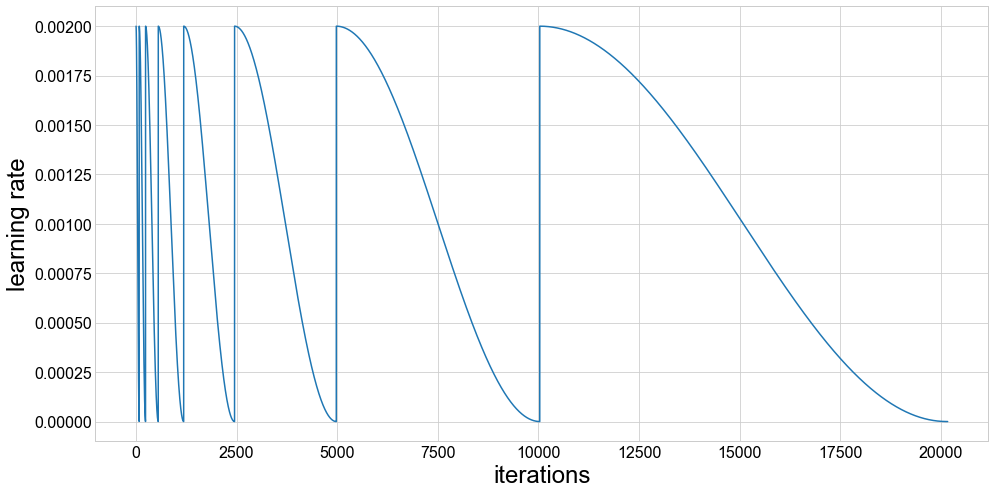

Fold took 142.541s

Training model 5 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109041). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7695317339547385e-05
2 New best found: 3.594978601937883e-05
3 New best found: 3.512910537919423e-05
5 New best found: 3.468170813509388e-05
6 New best found: 3.400478227916536e-05
7 New best found: 3.3940900349254946e-05
11 New best found: 3.351225117061784e-05
12 New best found: 3.347923991936799e-05
13 New best found: 3.335080592901069e-05
14 New best found: 3.3270811143229704e-05
15 New best found: 3.322059124937833e-05
24 New best found: 3.3135297169973085e-05
25 New best found: 3.309576266690508e-05
27 New best found: 3.297101028244651e-05
28 New best found: 3.295986751438473e-05
29 New best found: 3.2860905690454004e-05
52 New best found: 3.28245175801354e-05
55 New best found: 3.275436955400732e-05
CosineAnneal stalling after 127 epochs, entering redux decay at LR=0.0002937725133090065
128 New best found: 3.2751733395123025e-05
132 New best found: 3.274544210394453e-05
134 New best found: 3.274362252631917e-05
137 New best found: 3.273684011726388e-05
Early 

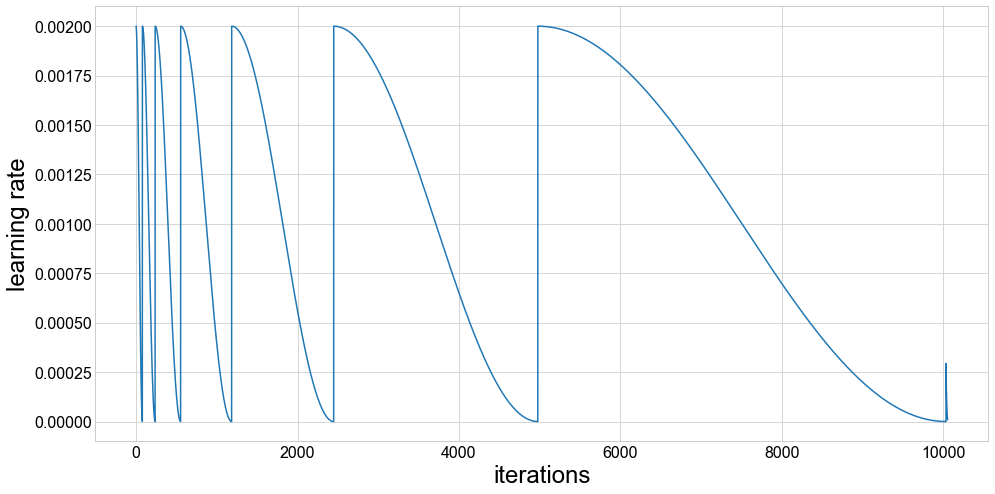

Fold took 80.561s

Training model 6 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116539). Check your callbacks.
  % delta_t_median)


1 New best found: 3.66263685098629e-05
2 New best found: 3.448911518413191e-05
3 New best found: 3.401647044342046e-05
5 New best found: 3.339327807868981e-05
6 New best found: 3.3083103737464726e-05
7 New best found: 3.2960004230603914e-05
11 New best found: 3.263400282064878e-05
12 New best found: 3.243498876978716e-05
14 New best found: 3.236908766085724e-05
15 New best found: 3.2348406093962706e-05
20 New best found: 3.2230389198761796e-05
25 New best found: 3.222169642603545e-05
27 New best found: 3.196161569285763e-05
29 New best found: 3.192110007179055e-05
31 New best found: 3.191937539733775e-05
47 New best found: 3.185444476595951e-05
54 New best found: 3.179927659832059e-05
56 New best found: 3.1745996627179325e-05
61 New best found: 3.1744462368873975e-05
62 New best found: 3.173622554909402e-05
63 New best found: 3.173551466340477e-05
CosineAnneal stalling after 255 epochs, entering redux decay at LR=7.721747127654725e-10
Early stopping after 265 epochs
Score is: {'loss': 

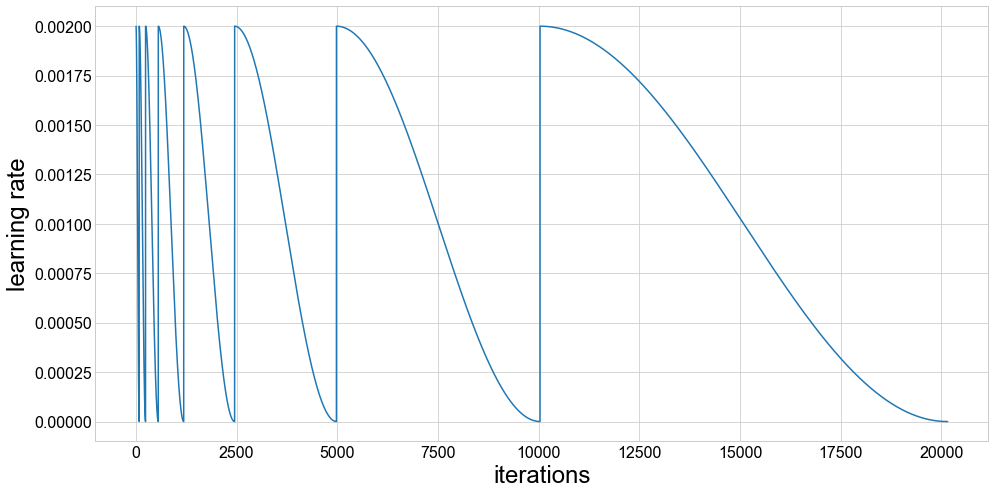

Fold took 148.011s

Training model 7 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127710). Check your callbacks.
  % delta_t_median)


1 New best found: 3.83540736010265e-05
2 New best found: 3.505753204316886e-05
3 New best found: 3.4453807110842736e-05
4 New best found: 3.390459890848729e-05
5 New best found: 3.3540489992503895e-05
6 New best found: 3.285245179118895e-05
7 New best found: 3.277450530596623e-05
11 New best found: 3.2719886800623646e-05
12 New best found: 3.234325947788074e-05
13 New best found: 3.214664743879198e-05
14 New best found: 3.20810260976384e-05
15 New best found: 3.2008559197537304e-05
24 New best found: 3.1922579009969463e-05
26 New best found: 3.184098902922062e-05
28 New best found: 3.1765413553441104e-05
29 New best found: 3.167158580814129e-05
30 New best found: 3.1659776560424644e-05
31 New best found: 3.165207383430133e-05
50 New best found: 3.159813793135656e-05
51 New best found: 3.155656774846775e-05
58 New best found: 3.155063406625142e-05
59 New best found: 3.151061362813914e-05
60 New best found: 3.148354500645754e-05
CosineAnneal stalling after 127 epochs, entering redux deca

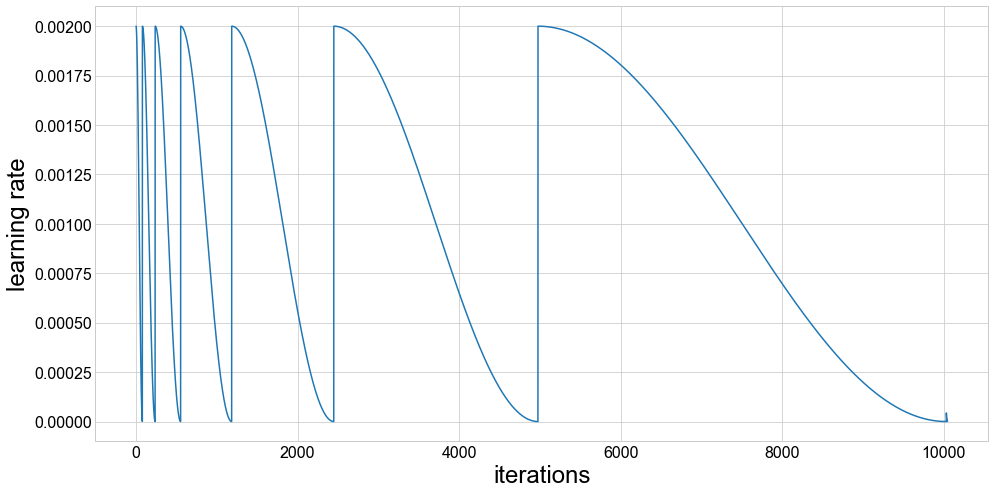

Fold took 80.654s

Training model 8 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.263044). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131832). Check your callbacks.
  % delta_t_median)


1 New best found: 3.760569007019955e-05
2 New best found: 3.5868638401962224e-05
3 New best found: 3.476742171767699e-05
4 New best found: 3.451055149250137e-05
5 New best found: 3.366932235879027e-05
6 New best found: 3.352975615667807e-05
7 New best found: 3.3342802482773897e-05
9 New best found: 3.331846358714148e-05
10 New best found: 3.2983998653705825e-05
12 New best found: 3.251906035452593e-05
14 New best found: 3.249592079142688e-05
15 New best found: 3.246601284596947e-05
26 New best found: 3.232865828105376e-05
27 New best found: 3.216816639283056e-05
28 New best found: 3.2063110205195096e-05
29 New best found: 3.2054104696142924e-05
30 New best found: 3.20450145461061e-05
54 New best found: 3.1981517573219855e-05
56 New best found: 3.188530718625741e-05
CosineAnneal stalling after 127 epochs, entering redux decay at LR=0.00022777852649451187
Early stopping after 137 epochs
Score is: {'loss': 3.188530718625741e-05, 'wAUC': 0.06333094545152107, 'AUC': 0.10077058735026134, 'AM

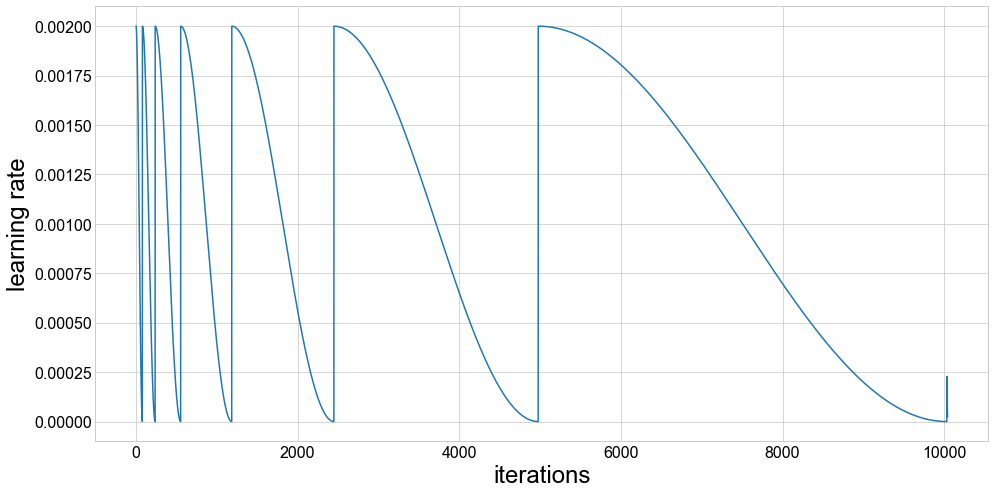

Fold took 78.103s

Training model 9 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.284615). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142658). Check your callbacks.
  % delta_t_median)


1 New best found: 3.5816067609994206e-05
2 New best found: 3.4347754366172015e-05
3 New best found: 3.327643922966672e-05
4 New best found: 3.282367617939599e-05
5 New best found: 3.233928812696831e-05
6 New best found: 3.175559860683279e-05
11 New best found: 3.16677319482551e-05
12 New best found: 3.155711098952452e-05
13 New best found: 3.130235423304839e-05
14 New best found: 3.117941732198233e-05
15 New best found: 3.114639491541311e-05
23 New best found: 3.1114388239802795e-05
24 New best found: 3.1027371367963494e-05
25 New best found: 3.091994162386982e-05
27 New best found: 3.085364908329211e-05
28 New best found: 3.080793859262485e-05
30 New best found: 3.0789790973358323e-05
31 New best found: 3.078795280453051e-05
55 New best found: 3.078506165475119e-05
57 New best found: 3.074240823916625e-05
58 New best found: 3.071513459726703e-05
59 New best found: 3.070588175323792e-05
60 New best found: 3.067220287193777e-05
61 New best found: 3.067050773242954e-05
CosineAnneal stall

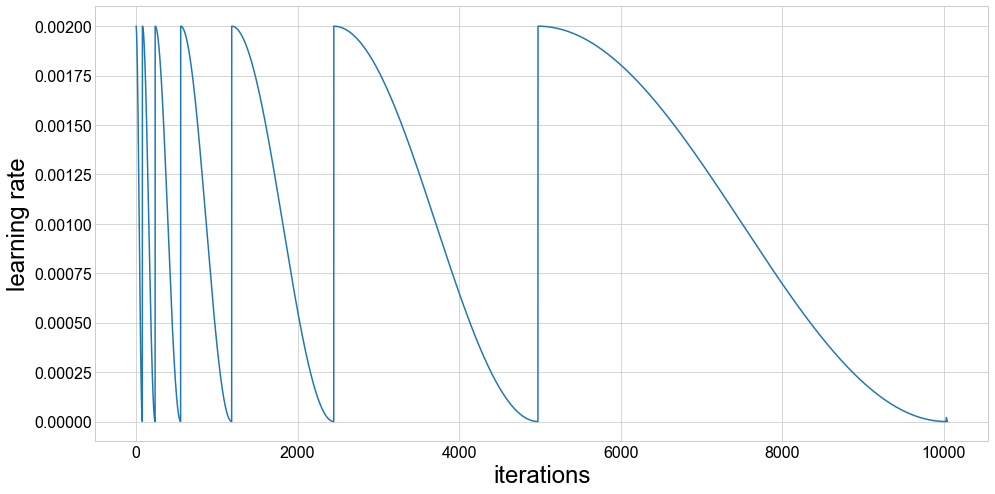

Fold took 83.673s

Training model 10 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.300367). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150514). Check your callbacks.
  % delta_t_median)


1 New best found: 3.697444009740138e-05
2 New best found: 3.474044332833728e-05
3 New best found: 3.4039725005277436e-05
5 New best found: 3.331647588784108e-05
6 New best found: 3.2861147649236956e-05
7 New best found: 3.2743597197986675e-05
9 New best found: 3.252639653364895e-05
11 New best found: 3.239724001614377e-05
12 New best found: 3.209951676253695e-05
13 New best found: 3.184202563134022e-05
14 New best found: 3.180180538620334e-05
15 New best found: 3.178767955687363e-05
21 New best found: 3.165363596490351e-05
26 New best found: 3.1549099180847406e-05
27 New best found: 3.149167574010789e-05
28 New best found: 3.144191037135897e-05
30 New best found: 3.140697953640483e-05
31 New best found: 3.140581178449793e-05
48 New best found: 3.1239563864073716e-05
55 New best found: 3.123667732434114e-05
57 New best found: 3.1147869452252055e-05
61 New best found: 3.113036697759526e-05
111 New best found: 3.108453482418554e-05
CosineAnneal stalling after 255 epochs, entering redux de

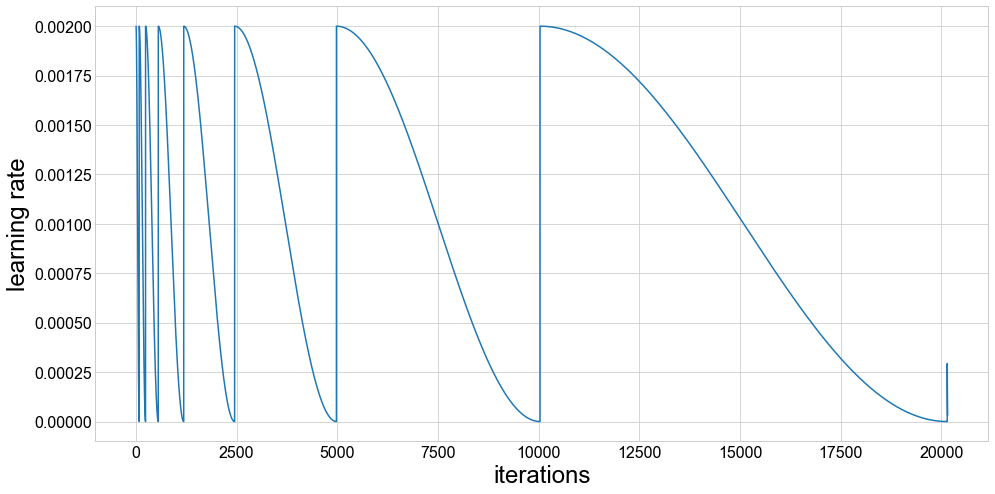

Fold took 154.816s


______________________________________
Training finished
Cross-validation took 1165.906s 


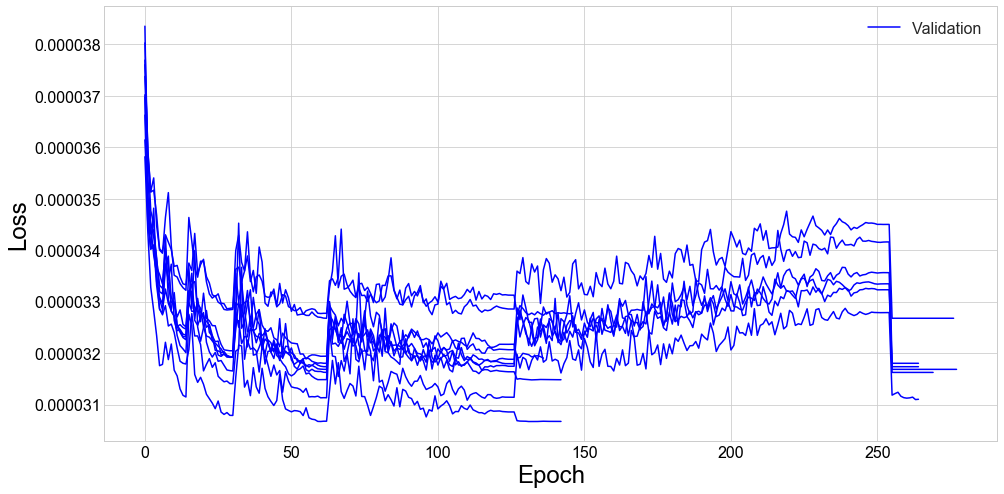

Mean loss = 3.17e-05 +- 2e-07
Mean wAUC = 0.0631 +- 0.0007
Mean AUC = 0.098 +- 0.001
Mean AMS = 3.83 +- 0.07
Mean cut = 0.963 +- 0.007
______________________________________



<Figure size 432x288 with 0 Axes>

In [13]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [14]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [15]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 8 with loss = 3.066953997913515e-05
Model 1 is 9 with loss = 3.108453482418554e-05
Model 2 is 6 with loss = 3.147912906404426e-05
Model 3 is 2 with loss = 3.162425054324558e-05
Model 4 is 3 with loss = 3.168372326045465e-05
Model 5 is 5 with loss = 3.173551466340477e-05
Model 6 is 1 with loss = 3.180160805140233e-05
Model 7 is 7 with loss = 3.188530718625741e-05
Model 8 is 0 with loss = 3.267703583551338e-05
Model 9 is 4 with loss = 3.273684011726388e-05


## Response on validation data

In [50]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [51]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00019526326740015065s per sample

Predicting fold 2 out of 10
Prediction took 0.0001950040148003609s per sample

Predicting fold 3 out of 10
Prediction took 0.0001957177918011439s per sample

Predicting fold 4 out of 10
Prediction took 0.00019669277439970755s per sample

Predicting fold 5 out of 10
Prediction took 0.00020382281600032s per sample

Predicting fold 6 out of 10
Prediction took 0.00019297840479994192s per sample

Predicting fold 7 out of 10
Prediction took 0.00019581694079970477s per sample

Predicting fold 8 out of 10
Prediction took 0.00020183812019968172s per sample

Predicting fold 9 out of 10
Prediction took 0.0002057608753995737s per sample

Predicting fold 10 out of 10
Prediction took 0.00019569407719973242s per sample



In [52]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9038387273653709, weighted 0.9360918562104962


In [53]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.9324670239796444, 0.9607415)

In [20]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.96+-0.01
Exact mean cut 0.9625897844089195, corresponds to calc_ams of 3.902399150025363
CPU times: user 3.32 s, sys: 4.92 s, total: 8.23 s
Wall time: 1min 27s


(4.0, 0.96)

With test-time augmentation we improve on 4_Model_Swish_Cyclical-LR in all metrics on validation data: overall AMS 3.77->3.90, AMS corresponding to mean cut 3.72->3.89.

# Test scoring

In [28]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [29]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00019409894430917285s per sample

Predicting fold 2 out of 10
Prediction took 0.0001918979906182027s per sample

Predicting fold 3 out of 10
Prediction took 0.0001996473959272738s per sample

Predicting fold 4 out of 10
Prediction took 0.00019209726069093448s per sample

Predicting fold 5 out of 10
Prediction took 0.00019095920012729368s per sample

Predicting fold 6 out of 10
Prediction took 0.00019289239545455943s per sample

Predicting fold 7 out of 10
Prediction took 0.00019090327409093417s per sample

Predicting fold 8 out of 10
Prediction took 0.00019109930352728539s per sample

Predicting fold 9 out of 10
Prediction took 0.00019102198763628787s per sample

Predicting fold 10 out of 10
Prediction took 0.00019235358098177875s per sample

CPU times: user 2min, sys: 12.1 s, total: 2min 12s
Wall time: 1min 45s


In [54]:
score_test_data(test_fy.source, 0.9625897844089195)

Public:Private AMS: 3.601039134176853 : 3.7200304626712044


(3.601039134176853, 3.7200304626712044)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)